## EUR/PLN Time series - Currency exchange rate predictions 2/3 - ARIMA Model

### Introduction

The ARMA incorporates both past values (like the AR) and past errors (like the MA). By including both, we should improve our estimates. This is because we are enabling our AR model to calibrate (by including how far off our predictions were) and also giving a benchmark (different from the constant) to the MA model, which should severely decrease the variation in the residuals. 

The ARIMA is just an integrated version of the ARMA model. What that means is, we simply integrate the data (however many times is needed) to get a stationary set.

To sum up. I will use:
- p for AR parameter
- d for I parameter
- q for MA parameter

So The ARIMA will have (p,d,q) order

### Imports

In [898]:
import pandas as pd
import numpy as np
import random
from pandas import datetime

import arch
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import boxcox
import pickle

import scipy.stats
import pylab

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from arch import arch_model

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.gofplots import qqplot

from scipy.stats import norm
from scipy.stats.distributions import chi2

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from arch import arch_model

from math import sqrt
import warnings
warnings.filterwarnings("ignore")

#### Save model function

In [518]:
def save_data(data, filename):
    filename = f'ARIMA_DATA/{filename}.pkl'
    outfile = open(filename,'wb')
    pickle.dump(model,outfile)
    outfile.close()
    

#### Load model function

In [517]:
def load_model(path_filename):
    try:
        pkl_file = open(path_filename, 'rb')
        mydata = pickle.load(pkl_file)
        pkl_file.close()
    except(e):
        print('Load error',e)
        pkl_file.close()
    return mydata

### Loading data from csv

In [307]:
df = pd.read_csv('Data/currencies_and_indicators.csv', index_col = 'Date')

In [308]:
df.head()

,USD,JPY,BGN,CZK,DKK,GBP,HUF,PLN,RON,SEK,...,Wydajność pracy (% r/r),Jednostkowe koszty pracy (% r/r),Produkt potencjalny (% r/r),Luka popytowa (% PKB potencjalnego),"Indeks cen surowców rolnych (USD; 2010=1,00)","Indeks cen surowców energetycznych (USD; 2010=1,00)",Poziom cen za granicą (% r/r),PKB za granicą (% r/r),Saldo rachunku bieżącego i rachunku kapitałowego (% PKB),WIBOR 3M (%)
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1.1789,133.73,NaN,35.107,7.4501,0.71110,251.48,4.0712,NaN,9.4696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,1.1790,130.96,NaN,34.917,7.4495,0.71220,250.80,4.0245,NaN,9.4025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-06,1.1743,131.42,NaN,34.850,7.4452,0.70760,250.67,4.0065,NaN,9.3050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-07,1.1632,129.43,NaN,34.886,7.4431,0.70585,250.09,4.0165,NaN,9.1800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-08,1.1659,130.09,NaN,34.938,7.4433,0.70940,250.15,4.0363,NaN,9.1650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
df.index= pd.to_datetime(df.index)
print(pd.infer_freq(df.index))
print(type(df.index[0]))

B
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Autocorrelation

We can assess the strength and type of relationship between the observations and their lags.

In statistics, this is called correlation, and when delay values in the time series are computed it is called autocorrelation. The correlation value calculated between two groups of numbers, such as the cases and their lag1 values, yields a number between -1 and 1.

The sign of the number indicates a negative or positive correlation, respectively. A value close to zero suggests weak correlation, while a value closer to -1 or 1 indicates strong correlation.

Correlation values, called correlation coefficients, can be calculated for each observation and for different delay values. Once calculated, you can create a graph to better understand how the relationship changes as the latency increases.

### Lag plot
Time series modeling assumes a relationship between a given observation and the previous one.

The previous observations in the time series are called lags. The observation in the previous step is lag1, the observation in the previous two time steps is lag2, and so on.

Pandas has a special type of graph that allows you to examine the relationship between the observation and the delay - lag_plot.

It plots the observations over time t on the x axis and observations lag1 (t-1) on the y axis.
- If the points are concentrated along a diagonal line from the lower left corner to the upper right corner of the graph, it suggests a positive correlation.
- If the points are converging along a diagonal from upper left to lower right, this suggests a negative correlation.
The more the observations adhere to the diagonal, the stronger the relation, and the more scattered they are, the weaker.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


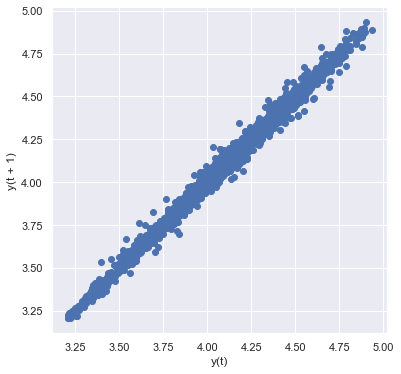

In [310]:
plt.figure(figsize=(6,6));
lag_plot(df.PLN)
plt.show()

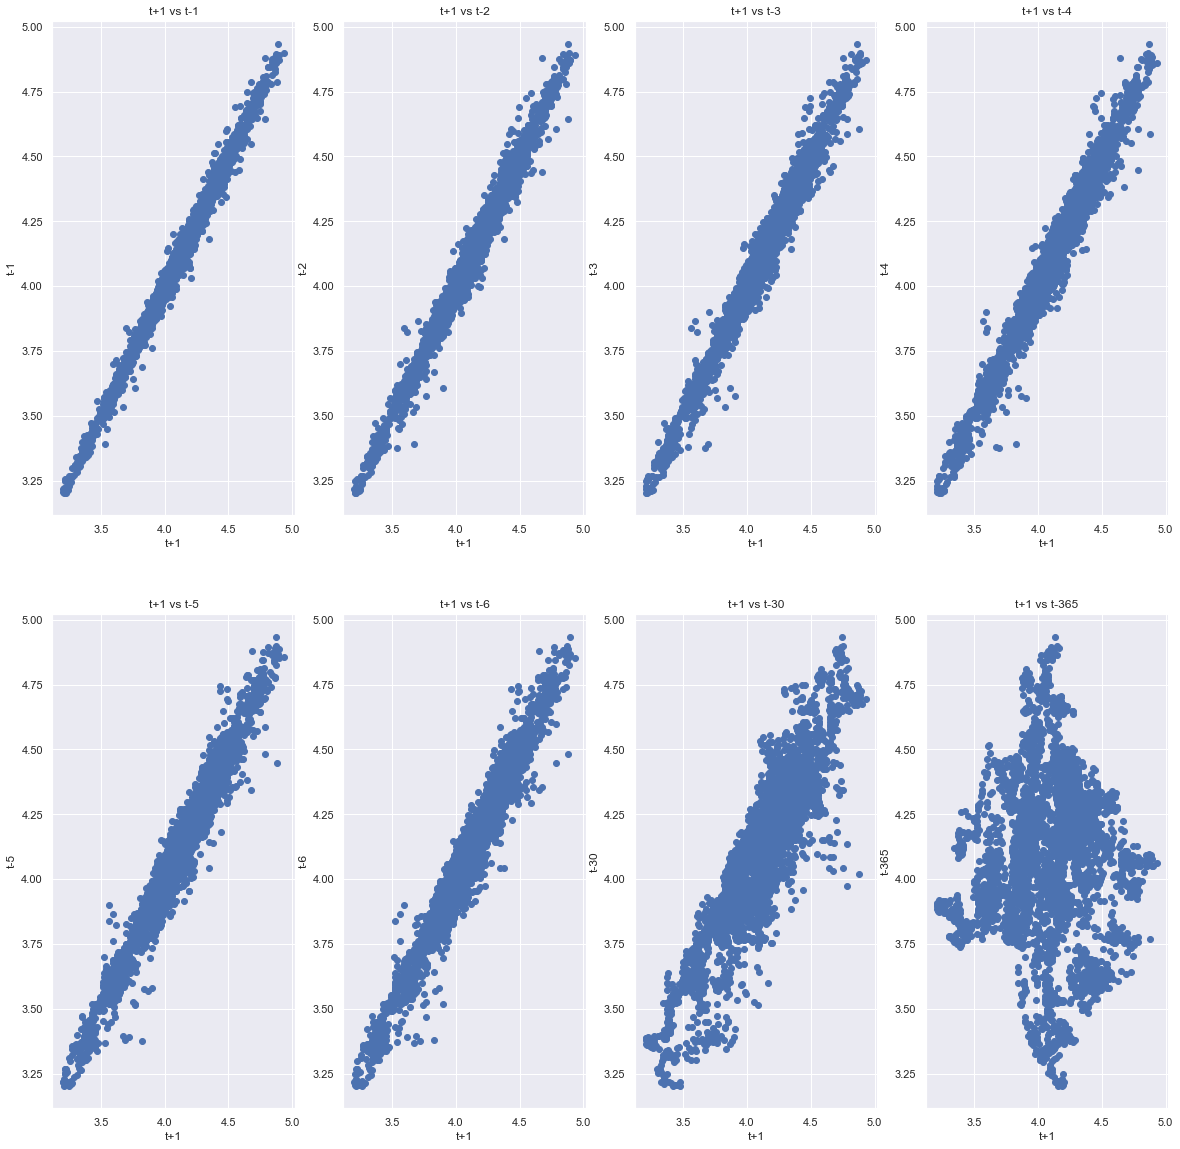

In [311]:
plt.figure(figsize=(20,20));
values = pd.DataFrame(df.PLN.values)
lags_values = [1, 2, 3, 4, 5, 6,30,365]
lags = len(lags_values)
columns = [values]
for i in lags_values:
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t+1']
for i in lags_values:
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i,ii in enumerate(lags_values, start = 1):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(ii))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(ii)].values)
    plt.xlabel('t+1')
    plt.ylabel('t-'+str(ii))
plt.show()

### Probability Plot

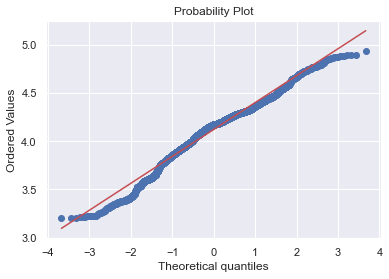

In [312]:
scipy.stats.probplot(df.PLN, plot = pylab)
pylab.show()

- Read line - What the data points should follow, if they are Normally Distributed.
- X line - How many standard deviatrions away from the mean thease values are.

We want to have data as similar to Normal Distribution as possible.

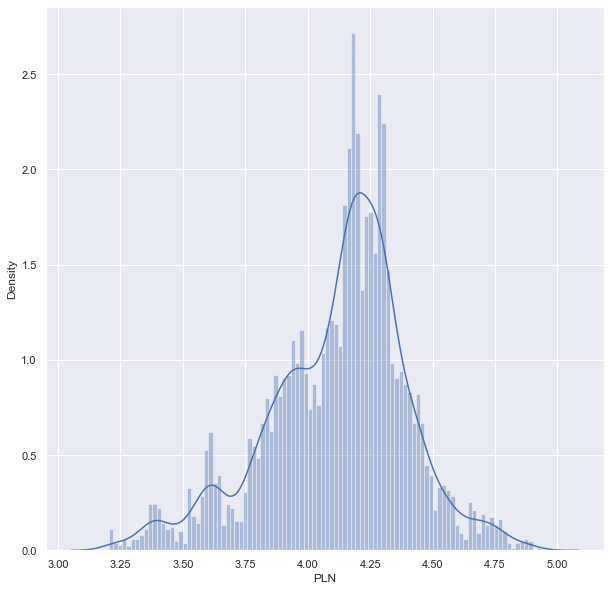

In [443]:
plt.figure(figsize = (10,10))
sns.distplot(df.PLN, bins = 100, label='EUR/PLN Histogram')
plt.show()

In [314]:
df[['PLN']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5701 entries, 1999-01-04 to 2020-11-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PLN     5701 non-null   float64
dtypes: float64(1)
memory usage: 89.1 KB


## Stationarity test 

To be able to build an ARIMA model, the data must be stationary:

- Have a constant average
- Constant variance
- Constant covariance

An example of a stationary waveform is White Noise

To check whether the data is stationary, I'm going to compare PLN data to White Noise and generated Random Walk data.

### White Nose

Definition:
White Noise is a random signal with equal intensities at every frequency and is often defined in statistics as a signal whose samples are a sequence of unrelated, random variables with no mean and limited variance. In some cases, it may be required that the samples are independent and have identical probabilities. Furthermore, when each sample has a normal distribution with no mean, the signal is labeled as additive white Gaussian noise. While in this context, white noise refers to a statistical signal, the concept of white noise extends to other technical disciplines such as physics, audio engineering, and telecommunications.

Source: https://deepai.org/machine-learning-glossary-and-terms/white-noise

In [353]:
s_df = df[['PLN']].copy()

In [354]:
wn = np.random.normal(loc = s_df.PLN.mean(), scale = s_df.PLN.std(), size = len(s_df))
s_df['wn'] = wn

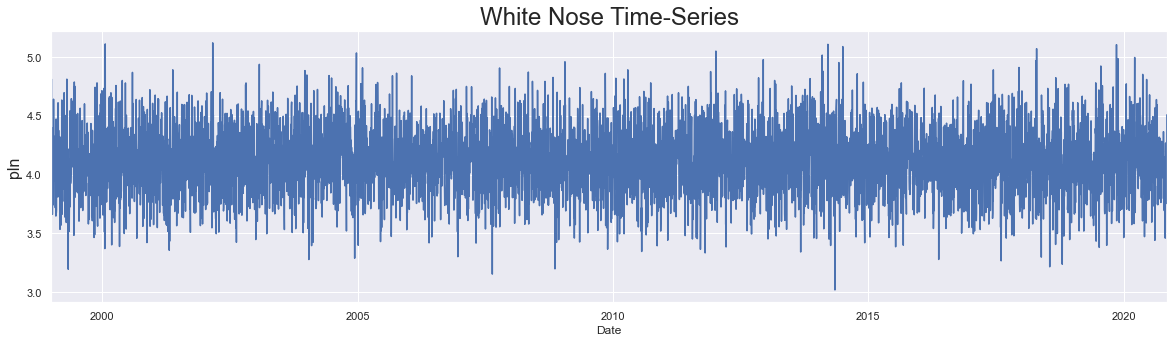

In [355]:
s_df.wn.plot(figsize = (20,5))
plt.title('White Nose Time-Series', size = 24)
plt.ylabel('pln',size = 16)
plt.show()

### Random Walk

Definition:
In mathematics, a random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.

Source: https://en.wikipedia.org/wiki/Random_walk

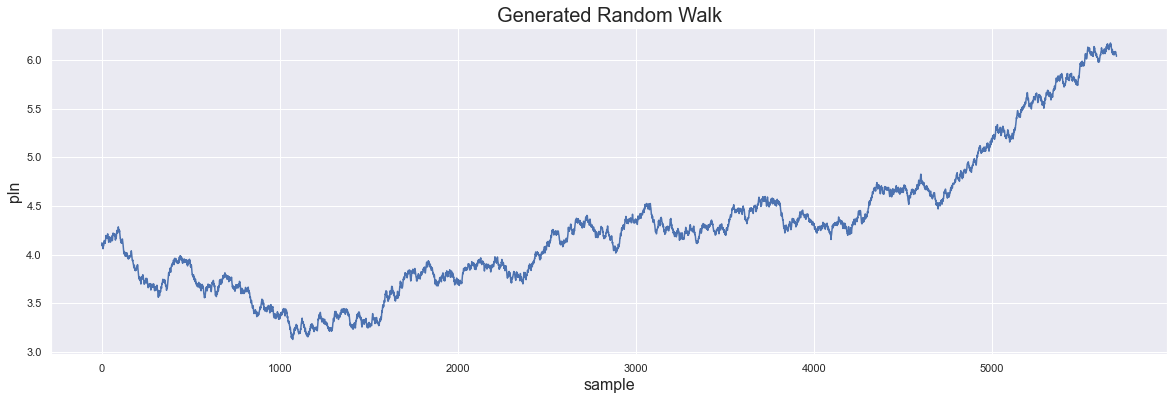

In [356]:
random.seed(43)
pln_mean = s_df['PLN'].mean()
pln_std = s_df['PLN'].std()
pln_len = len(s_df)
rw = list()
rw.append(pln_mean)
for i in range(1, pln_len):
    movement = -1 if random.random() < 0.5 else 1
    value = rw[i-1] + movement*random.random()*pln_std*0.1
    rw.append(value)
plt.figure(figsize=(20,6))
plt.title('Generated Random Walk', size = 20)
plt.xlabel('sample',size = 16)
plt.ylabel('pln',size = 16)
plt.plot(rw)
plt.show()

In [357]:
s_df['rw'] = rw

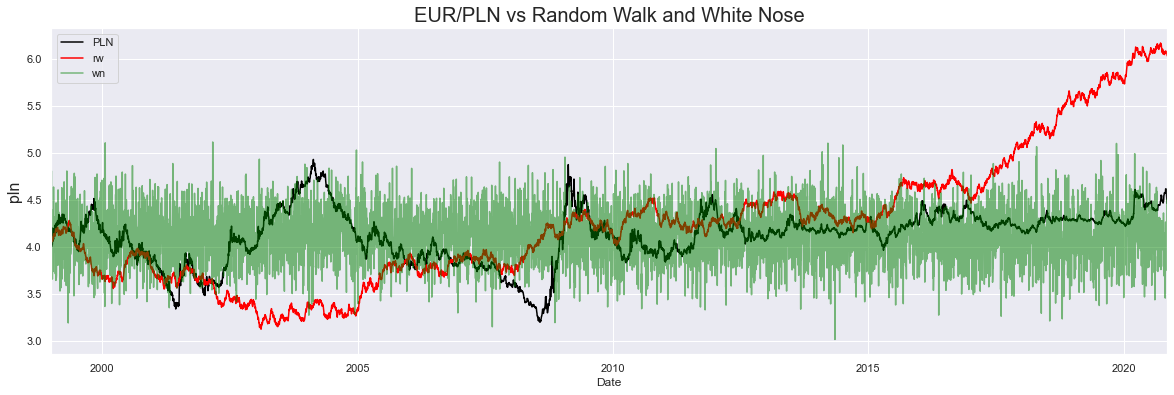

In [358]:
plt.figure(figsize=(20,6))
s_df.PLN.plot(color = 'black')
s_df.rw.plot(color = 'red')
s_df.wn.plot(color = 'green', alpha = 0.5)
plt.title('EUR/PLN vs Random Walk and White Nose', size = 20)
plt.ylabel('pln',size = 16)
plt.legend()
plt.show()

As you can see, the EUR / PLN chart is not similar to the White Noise and Random Walk.
To find out, let's perform the Augmented Dickey-Fuller test.

### Stationarity test 

In [428]:
def test_stationarity(timeseries, n = 12):
    rolmean = timeseries.rolling(n).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(n).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,6));
    timeseries.plot(color='blue',label='Original', alpha = 0.4)
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    plt.locator_params(axis='x', nbins=10)
    plt.legend(loc='best')
    plt.title('Original & Rolling Mean & Standard Deviation', size = 20)
    plt.ylabel('pln',size = 14)
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = sts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Stationarity EUR/PLN data test

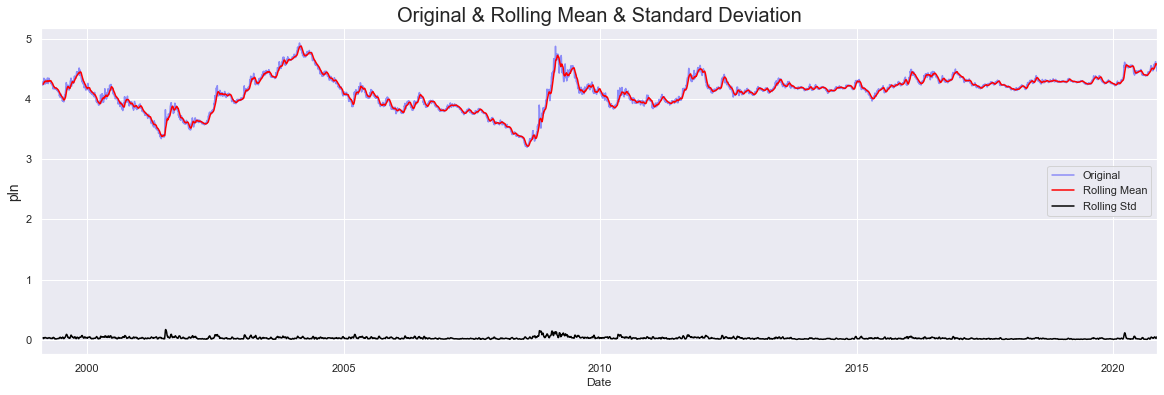

Results of Dickey-Fuller Test:
Test Statistic                   -2.924653
p-value                           0.042555
#Lags Used                        0.000000
Number of Observations Used    5676.000000
Critical Value (1%)              -3.431503
Critical Value (5%)              -2.862049
Critical Value (10%)             -2.567041
dtype: float64


In [430]:
test_stationarity(s_df.PLN, n = 12)

Although the p-value is less than 0.05, the statistical test value is not less than the critical value for 1%, so we cannot reject the hypothesis that the data are non-stationary.

#### Stationarity White Nose test

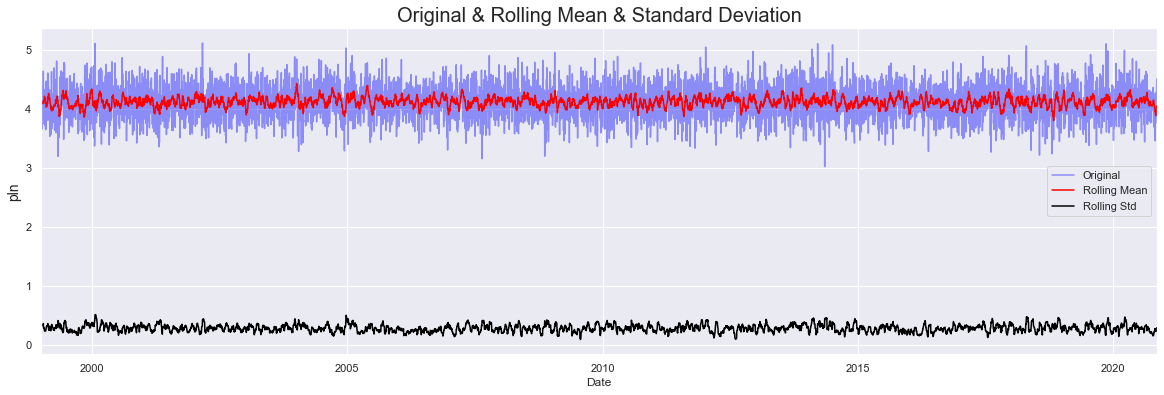

Results of Dickey-Fuller Test:
Test Statistic                  -75.088644
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5700.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


In [361]:
test_stationarity(s_df.wn, n = 12)

The p-value is 0 and the statistical test value is significantly lower than the critical value, therefore we can reject the H0 hypothesis about the non-stationarity of the course.

#### Stationarity Random Walk test

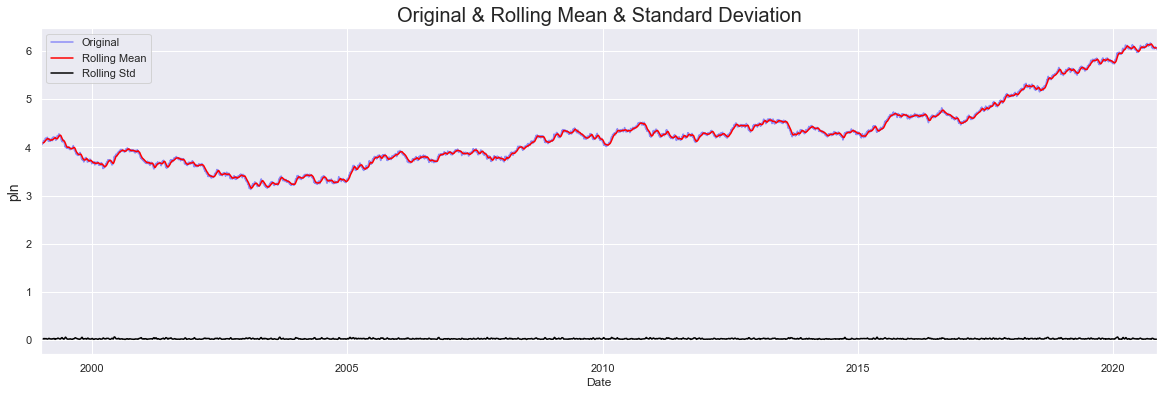

Results of Dickey-Fuller Test:
Test Statistic                    0.961394
p-value                           0.993841
#Lags Used                        0.000000
Number of Observations Used    5700.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


In [362]:
test_stationarity(s_df.rw, n = 12)

The high p-value and the low value of the Statistical test indicate that the H0 hypothesis is true.

#### Compare Diff_1, RW, WN, ACF & PACF Plots

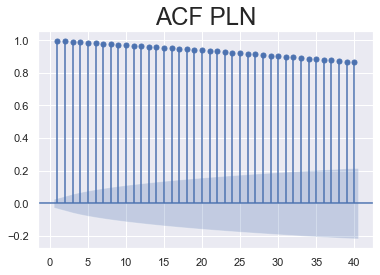

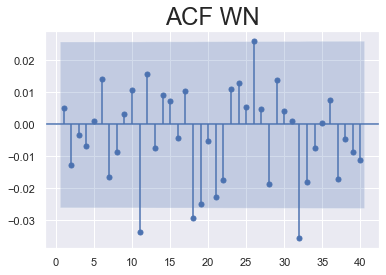

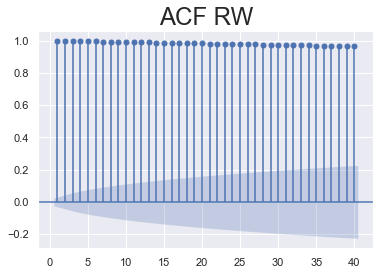

In [381]:
sgt.plot_acf(s_df.PLN, lags = 40, zero = False)
plt.title("ACF PLN", size = 24)
sgt.plot_acf(s_df.wn, lags = 40, zero = False)
plt.title("ACF WN", size = 24)
sgt.plot_acf(s_df.rw, lags = 40, zero = False)
plt.title("ACF RW", size = 24)
plt.show()

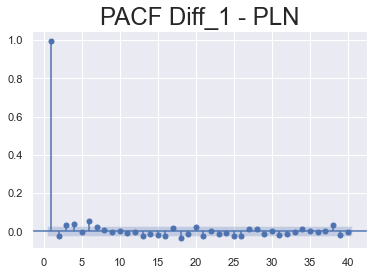

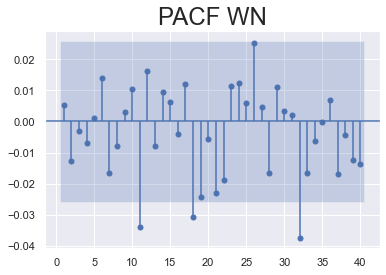

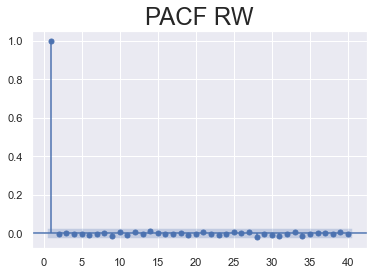

In [382]:
sgt.plot_pacf(s_df.PLN, lags = 40, zero = False)
plt.title("PACF Diff_1 - PLN", size = 24)
sgt.plot_pacf(s_df.wn, lags = 40, zero = False)
plt.title("PACF WN", size = 24)
sgt.plot_pacf(s_df.rw, lags = 40, zero = False)
plt.title("PACF RW", size = 24)
plt.show()

ACF & PACF plots for EUR/PLN, WN, RW show how plots can be different if the series is fully stationary or not. For White Nose there are no correlations between present and past values.

### Transforming data

It possible to make data stationary. To do it I have to use one of the transformation. Each of the transformations is reversible.

#### Data transformation - Log + moving average

In [363]:
n_avg = 12

In [364]:
s_df['log'] = np.log(s_df.PLN)

In [365]:
s_df['log_moving_avg'] = s_df.log.rolling(n_avg).mean()

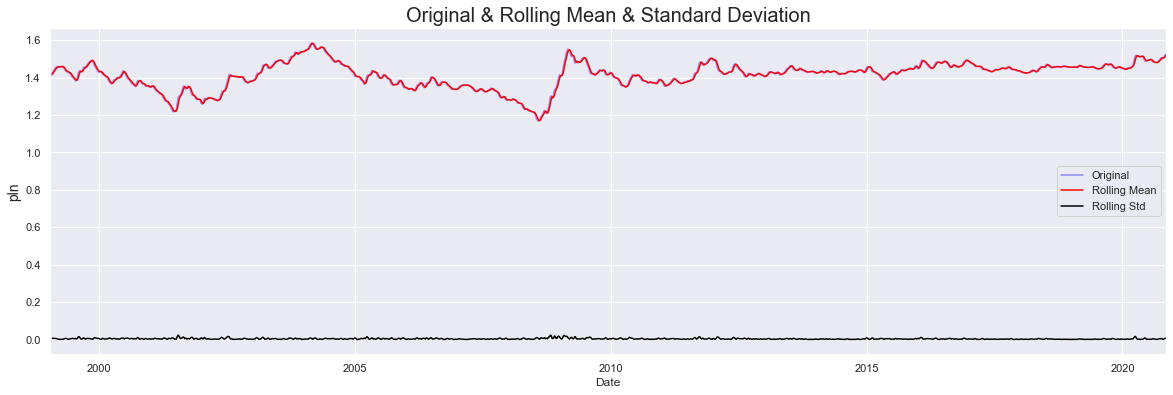

Results of Dickey-Fuller Test:
Test Statistic                   -0.100105
p-value                           0.949428
#Lags Used                        0.000000
Number of Observations Used    5688.000000
Critical Value (1%)              -3.431500
Critical Value (5%)              -2.862048
Critical Value (10%)             -2.567041
dtype: float64


In [367]:
test_stationarity(s_df.log_moving_avg[n_avg:])

The series is not stationary.P-value is grater than 0.05.

#### Data transformation - Log moving average differences

In [368]:
s_df['log_moving_avg_diff'] = s_df.log - s_df.log_moving_avg

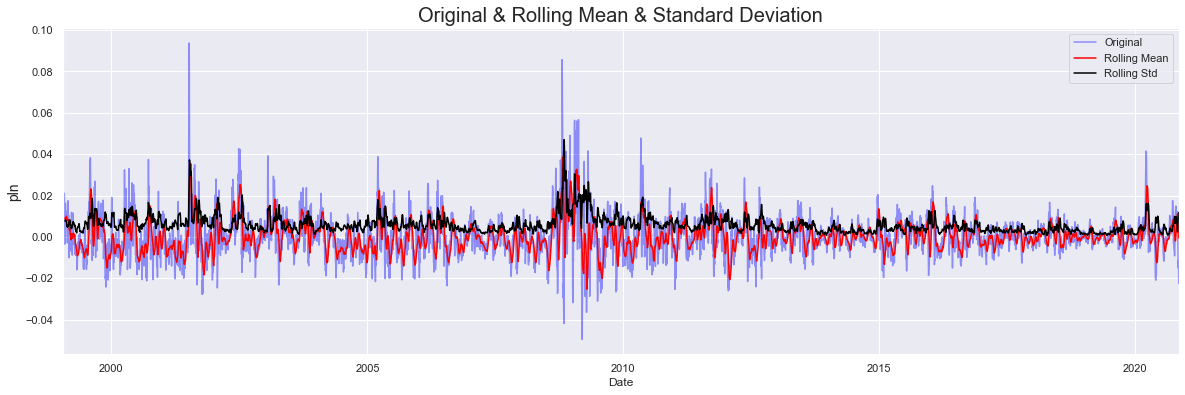

Results of Dickey-Fuller Test:
Test Statistic                  -21.124244
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5688.000000
Critical Value (1%)              -3.431500
Critical Value (5%)              -2.862048
Critical Value (10%)             -2.567041
dtype: float64


In [369]:
test_stationarity(s_df.log_moving_avg_diff[n_avg:])

The mean values vary slightly, but there is no specific trend. Moreover, the test statistic is less than 1% of the critical values, so we can conclude that it is a stationary series.

#### Data transformation - Expwighted avg

In [370]:
s_df['expwighted_avg'] = s_df.log.ewm(halflife=n_avg).mean()

In [371]:
s_df['log_ewma_diff'] = s_df.log - s_df.expwighted_avg

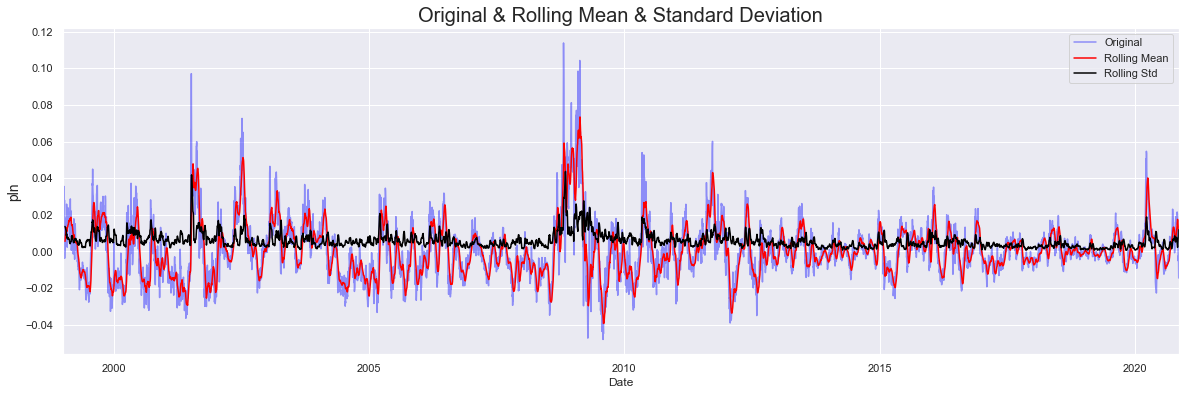

Results of Dickey-Fuller Test:
Test Statistic                -1.326221e+01
p-value                        8.354427e-25
#Lags Used                     0.000000e+00
Number of Observations Used    5.700000e+03
Critical Value (1%)           -3.431498e+00
Critical Value (5%)           -2.862047e+00
Critical Value (10%)          -2.567040e+00
dtype: float64


In [372]:
test_stationarity(s_df.log_ewma_diff)

Expwighted avg makes series stationary.

#### Data transformation - Returns

This transformation is highly used in finance.

In [373]:
s_df['returns'] = s_df.PLN.pct_change(1).mul(100)

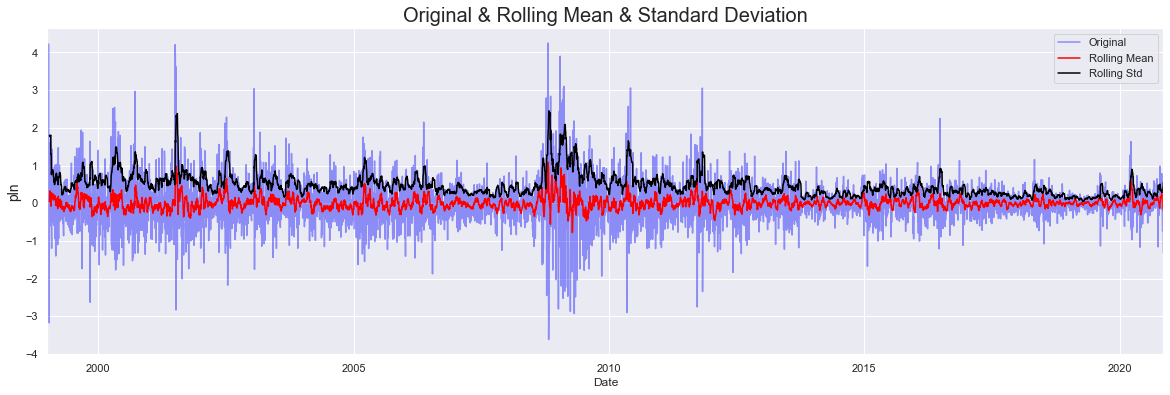

Results of Dickey-Fuller Test:
Test Statistic                  -73.875307
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5699.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


In [374]:
test_stationarity(s_df.returns[1:])

As a result we get stationary series. 

#### Data transformation - Diff(1) - calculatrions

In [375]:
s_df['diff_1'] = s_df.PLN.diff(1)

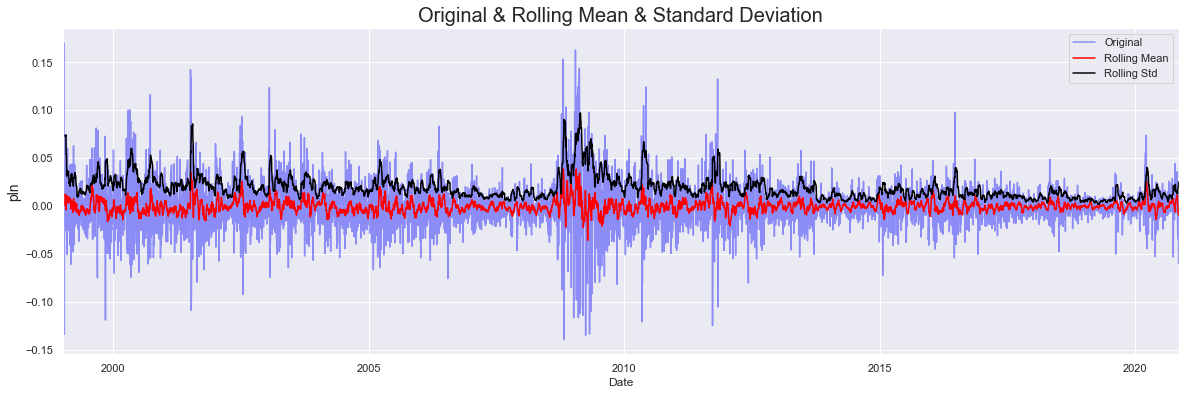

Results of Dickey-Fuller Test:
Test Statistic                  -74.237910
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5699.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


In [376]:
test_stationarity(s_df.diff_1[1:])

Bardzo prosta transformacja i bardzo skuteczna sprawia, że seria jest stacjonarna. Wykorzystam tę transformację do mojego modelu ARIMA.

#### Data transformation - Seasonal decompose

This is a cycle that repeats over time, such as monthly or yearly.

In [456]:
s_dec_additive = seasonal_decompose(s_df.PLN, model = "additive", period = 10)

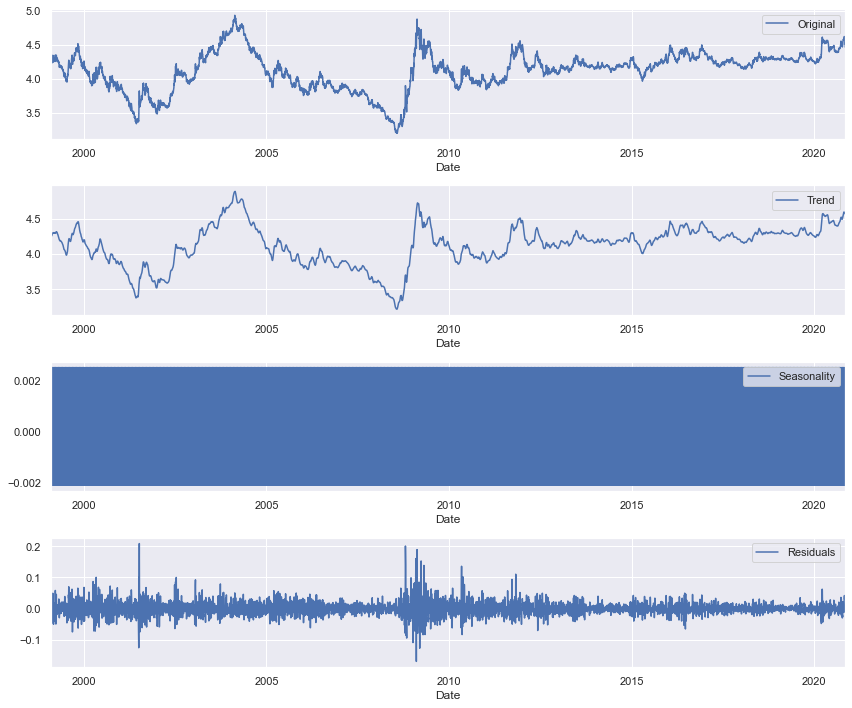

In [457]:
plt.figure(figsize=(12,10))
plt.subplot(411)
s_dec_additive.observed.plot(label='Original')
plt.legend(loc='best')
plt.subplot(412)
s_dec_additive.trend.plot(label='Trend')
plt.legend(loc='best')
plt.subplot(413)
s_dec_additive.seasonal.plot(label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
s_dec_additive.resid.plot( label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [452]:
s_dec_multiplicative = seasonal_decompose(s_df.PLN, model = "multiplicative", period = 14)

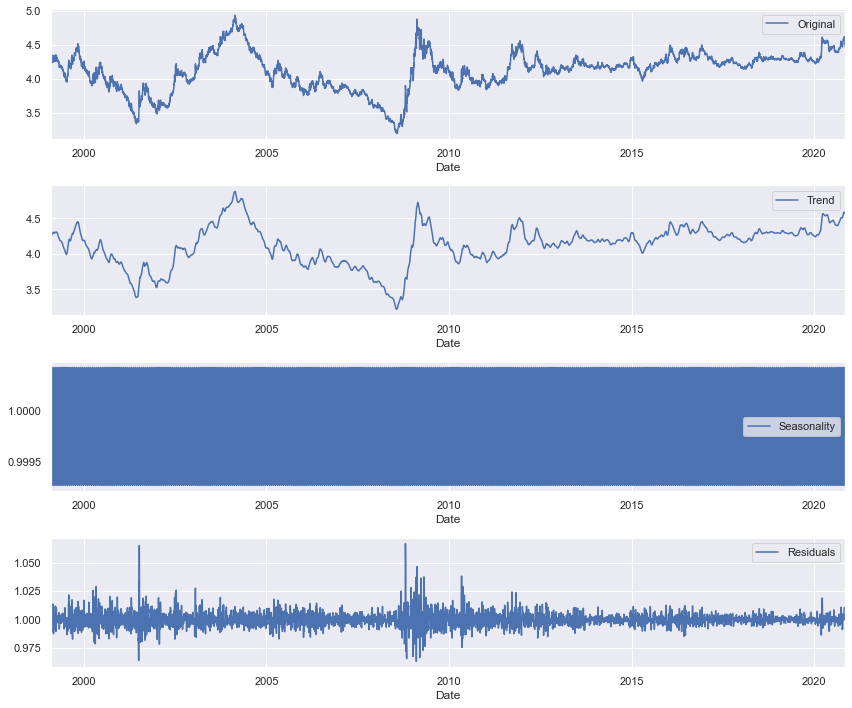

In [453]:
plt.figure(figsize=(12,10))
plt.subplot(411)
s_dec_multiplicative.observed.plot(label='Original')
plt.legend(loc='best')
plt.subplot(412)
s_dec_multiplicative.trend.plot(label='Trend')
plt.legend(loc='best')
plt.subplot(413)
s_dec_multiplicative.seasonal.plot(label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
s_dec_multiplicative.resid.plot( label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Both seasonality(additive, multiplicative) show that EUR/PLN is not seasonal.

## Adding exogenous variables

Exogenous variable is one whose value is determined outside the model and is imposed on the model, and an exogenous change is a change in an exogenous variable. 
I will add few features that I'm going to use in ARIMAX mode. 

In [458]:
s_df.diff_1.isna().sum()

0

In [459]:
s_df.head(13)

,PLN,wn,rw,log,log_moving_avg,log_moving_avg_diff,expwighted_avg,log_ewma_diff,returns,diff_1,lag_1,lag_2,lag_3,lag_4,lag_5,CHF_lag_5,HUF_lag_5,NOK_lag_5,Exch rate_lag_5
Date,,,,,,,,,,,,,,,,,,,
1999-02-05,4.1753,3.647399,4.171827,1.429186,1.428729,0.000457,1.421648,0.007538,0.580555,0.0241,4.1512,4.2014,4.2296,4.2360,4.1610,1.6123,249.24,8.5785,102.2517
1999-02-08,4.1958,4.472381,4.173245,1.434084,1.430093,0.003991,1.422546,0.011538,0.490983,0.0205,4.1753,4.1512,4.2014,4.2296,4.2360,1.6089,248.97,8.5395,101.6738
1999-02-09,4.2560,3.673364,4.183661,1.448330,1.432020,0.016310,1.424378,0.023952,1.434768,0.0602,4.1958,4.1753,4.1512,4.2014,4.2296,1.6002,248.99,8.5845,99.7975
1999-02-10,4.2448,3.700253,4.166554,1.445695,1.433688,0.012007,1.425871,0.019824,-0.263158,-0.0112,4.2560,4.1958,4.1753,4.1512,4.2014,1.5975,249.00,8.6250,99.8840
1999-02-11,4.2520,4.401567,4.182175,1.447389,1.435037,0.012352,1.427357,0.020033,0.169619,0.0072,4.2448,4.2560,4.1958,4.1753,4.1512,1.6017,248.77,8.6425,100.5745
1999-02-12,4.2302,4.421733,4.168168,1.442249,1.436456,0.005794,1.428372,0.013877,-0.512700,-0.0218,4.2520,4.2448,4.2560,4.1958,4.1753,1.6012,248.91,8.6725,101.6780
1999-02-15,4.2612,4.187210,4.195201,1.449551,1.438898,0.010652,1.429799,0.019752,0.732826,0.0310,4.2302,4.2520,4.2448,4.2560,4.1958,1.6018,248.64,8.6200,101.1285
1999-02-16,4.2747,4.347941,4.196371,1.452714,1.441145,0.011569,1.431325,0.021389,0.316812,0.0135,4.2612,4.2302,4.2520,4.2448,4.2560,1.5999,249.75,8.6505,100.6040
1999-02-17,4.2790,3.984748,4.213404,1.453719,1.441987,0.011733,1.432802,0.020918,0.100592,0.0043,4.2747,4.2612,4.2302,4.2520,4.2448,1.5963,251.05,8.6425,99.4390


### Adding Lags

In [460]:
lags = 5
for i in range(1,lags+1):
    s_df[f'lag_{i}'] = s_df.PLN.shift(i)

### Adding Currencies - CHF, HUF, NOK, Exch rate with lag 5

In [461]:
df.columns

Index(['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'HUF', 'PLN', 'RON', 'SEK',
       'CHF', 'NOK', 'HRK', 'RUB', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY', 'HKD',
       'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD', 'THB',
       'ZAR', 'Bieżąca ogólna sytuacja gospodarcza przedsiębiorstwa, ogółem',
       'Bieżący wskaźnik ufności konsumenckiej',
       'Ceny towarów i usług konsumpcyjnych - ogółem',
       'Dług skarbu państwa, ogółem',
       'Dług zagraniczny skarbu państwa, ogółem',
       'Handel zagraniczny wg GUS - eksport ogółem',
       'Handel zagraniczny wg GUS - saldo ogółem',
       'Handel zagraniczny wg GUS - import ogółem',
       'Mediana prognoz wzrostu PKB Polski w 2020 r.',
       'Międzynarodowa pozycja inwestycyjna, międzynarodowa pozycja inwestycyjna netto',
       'Nakłady brutto na środki trwałe',
       'Oprocentowanie nowych depozytów, ogółem ',
       'Oprocentowanie nowych kredytów, ogółem',
       'Produkt krajowy brutto (PKB)',
       'Sprzedaż p

In [791]:
s_df['CHF_lag_5'] = df['CHF'].shift(5)
s_df['HUF_lag_5'] = df['HUF'].shift(5)
s_df['NOK_lag_5'] = df['NOK'].shift(5)
s_df['Exch rate_lag_5'] = df['Exch rate'].shift(5)


In [792]:
s_df.head(13)

,PLN,wn,rw,log,log_moving_avg,log_moving_avg_diff,expwighted_avg,log_ewma_diff,returns,diff_1,...,lag_3,lag_4,lag_5,CHF_lag_5,HUF_lag_5,NOK_lag_5,Exch rate_lag_5,CHF_lag_2,HUF_lag_2,NOK_lag_2
Date,,,,,,,,,,,,,,,,,,,,,
1999-02-23,4.2408,4.512061,4.152994,1.444752,1.447653,-0.002901,1.436663,0.008089,-0.469395,-0.0200,...,4.2840,4.2790,4.2747,1.5975,249.56,8.6205,98.7249,1.5982,251.88,8.7075
1999-02-24,4.2813,3.967683,4.151920,1.454257,1.449334,0.004922,1.437774,0.016482,0.955008,0.0405,...,4.2589,4.2840,4.2790,1.5973,251.09,8.6955,99.1901,1.5986,250.12,8.6885
1999-02-25,4.3051,4.375994,4.126350,1.459800,1.450290,0.009510,1.439156,0.020645,0.555906,0.0238,...,4.2608,4.2589,4.2840,1.5982,252.06,8.7385,98.8922,1.5954,249.90,8.6745
1999-02-26,4.3482,4.129752,4.129868,1.469762,1.452296,0.017466,1.441063,0.028699,1.001138,0.0431,...,4.2408,4.2608,4.2589,1.5982,251.88,8.7075,99.3141,1.5940,252.23,8.6540
1999-03-01,4.3074,4.225349,4.157862,1.460334,1.453374,0.006960,1.442256,0.018078,-0.938319,-0.0408,...,4.2813,4.2408,4.2608,1.5986,250.12,8.6885,98.6062,1.5905,252.56,8.6965
1999-03-02,4.3210,3.809686,4.182908,1.463487,1.455144,0.008343,1.443563,0.019924,0.315736,0.0136,...,4.3051,4.2813,4.2408,1.5954,249.90,8.6745,98.0804,1.5890,253.91,8.6965
1999-03-03,4.3370,3.929164,4.162610,1.467183,1.456614,0.010569,1.445010,0.022173,0.370285,0.0160,...,4.3482,4.3051,4.2813,1.5940,252.23,8.6540,97.0585,1.5930,254.53,8.6475
1999-03-04,4.3093,4.156915,4.136083,1.460775,1.457285,0.003490,1.445970,0.014805,-0.638690,-0.0277,...,4.3074,4.3482,4.3051,1.5905,252.56,8.6965,97.8587,1.5912,252.14,8.6520
1999-03-05,4.2490,4.320838,4.159959,1.446684,1.456699,-0.010015,1.446013,0.000670,-1.399299,-0.0603,...,4.3210,4.3074,4.3482,1.5890,253.91,8.6965,97.3699,1.5926,254.02,8.6475


In [464]:
s_df = s_df.iloc[12:]

In [465]:
s_df.isna().sum()

PLN                    0
wn                     0
rw                     0
log                    0
log_moving_avg         0
log_moving_avg_diff    0
expwighted_avg         0
log_ewma_diff          0
returns                0
diff_1                 0
lag_1                  0
lag_2                  0
lag_3                  0
lag_4                  0
lag_5                  0
CHF_lag_5              0
HUF_lag_5              0
NOK_lag_5              0
Exch rate_lag_5        0
dtype: int64

## Splitting the Data

In [413]:
size = int(len(s_df)*0.80)

### Train data 

In [416]:
s_df.shape

(5677, 19)

In [417]:
df_train = s_df.iloc[:size]

### Test data

In [418]:
df_test = s_df.iloc[size:]

In [419]:
start_date = df_test.index.min()
end_date = df_test.index.max()

In [420]:
start_date,end_date

(Timestamp('2016-07-04 00:00:00'), Timestamp('2020-11-09 00:00:00'))

In [421]:
df.index.min(),df.index.max()

(Timestamp('1999-01-04 00:00:00'), Timestamp('2020-11-09 00:00:00'))

In [422]:
df['train'] = df_train.PLN
df['test'] = df_test.PLN

### Plot train and test data

In [702]:
def combine_plots(train, test, predict = None, index = None, zoom_start = None,zoom_end = None, Title = ''):
    def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)
    cmap = get_cmap(20)
    temp_df = pd.DataFrame(index = index)
    temp_df['test'] = test
    temp_df['train'] = train
    
    temp_df[zoom_start:zoom_end].train.plot(figsize= (20,8), color = cmap(1), legend = 'Train')
    temp_df[zoom_start:zoom_end].test.plot(color = cmap(8), alpha = 0.5, legend = 'Test')
    if predict is not None:
        cmap = get_cmap(len(predict)+1)
        for i,c in enumerate(predict, start=1):
            temp_df_pred = pd.DataFrame(c[0],index =test.index )
            temp_df[f'predict_{i}'] = temp_df_pred
            temp_df.loc[zoom_start:zoom_end,f'predict_{i}'].plot( alpha = 0.8, legend = 'Predict')#color = cmap(5*i+5),
    plt.ylabel('pln')
    plt.title(f'EUR/PLN Train and Test Data {Title}', size = 20)
    plt.show()

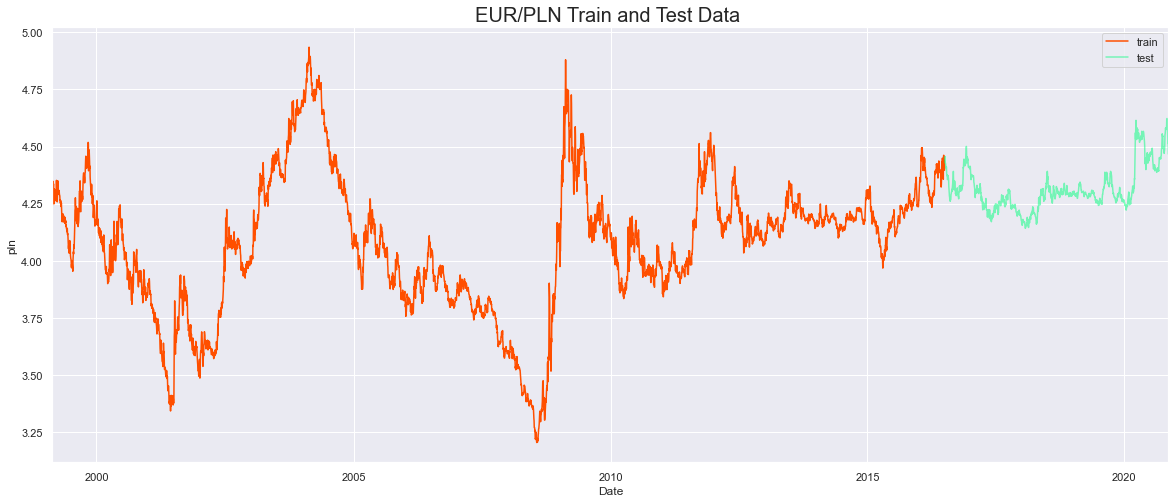

In [703]:
combine_plots(df_train.PLN,df_test.PLN,index = s_df.index)

## Building ARIMA model

### ACF & PACF for PLN

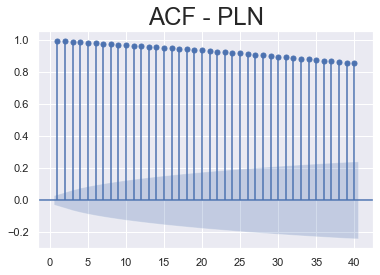

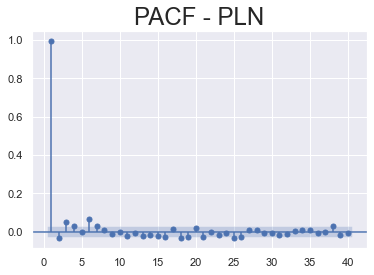

In [431]:
sgt.plot_acf(df_train.PLN, lags = 40, zero = False)
plt.title("ACF - PLN", size = 24)
sgt.plot_pacf(df_train.PLN, lags = 40, zero = False)
plt.title("PACF - PLN", size = 24)
plt.show()

We known that ACF plot can tell as how many lags we need in part MA of the model.

PACF is telling as how many lags we need in part AR of the model

### ARMA Manual

### ACF & PACF for Diff_1

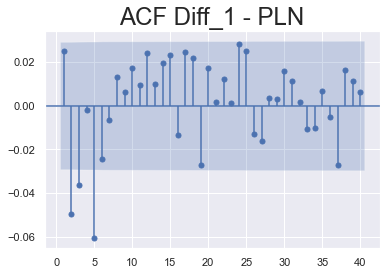

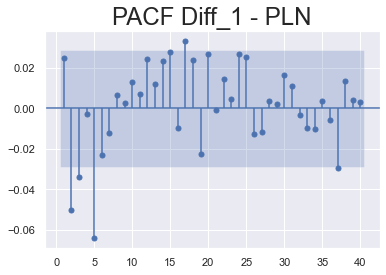

In [426]:
sgt.plot_acf(df_train.diff_1, lags = 40, zero = False)
plt.title("ACF Diff_1 - PLN", size = 24)
sgt.plot_pacf(df_train.diff_1, lags = 40, zero = False)
plt.title("PACF Diff_1 - PLN", size = 24)
plt.show()

Plots show that lags from 1 to 5 are significant. So I can start to build model with the order p = 5 and q = 5. I will use diff_1 transformation so for now I will use ARMA model instead of ARIMA.

### ARMA(5,5)

In [469]:
start = datetime.now()
model_ar_5_ma_5 = ARMA(df_train.diff_1, order=(5,5))
results_ar_5_ma_5 = model_ar_5_ma_5.fit()#update_freq = 5

end = datetime.now()
print(f'Line end at: {end}')
print(f'The process took: {end - start}')


Line end at: 2020-12-11 15:56:14.976327
The process took: 0:00:28.417014


In [470]:
results_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 diff_1   No. Observations:                 4541
Model:                     ARMA(5, 5)   Log Likelihood               10360.529
Method:                       css-mle   S.D. of innovations              0.025
Date:                Fri, 11 Dec 2020   AIC                         -20697.057
Time:                        15:56:15   BIC                         -20620.006
Sample:                    02-05-1999   HQIC                        -20669.920
                         - 07-01-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.227e-05      0.000      0.163      0.870      -0.001       0.001
ar.L1.diff_1     0.2674      0.241      1.112      0.266      -0.204       0.739
ar.L2.diff_1     0.3757      0.370      1.014      0.311      -0.350       1.102
ar.L3.diff_1    -0.0563      0.228     -0.247      0.805      -0.504       0.391
ar.L4.diff_1     0.0831      0.284      0.292      0.770      -0.474       0.640
ar.L5.diff_1    -0.3660      0.199     -1.835      0.066      -0.757       0.025
ma.L1.diff_1    -0.2473      0.243     -1.018      0.309      -0.723       0.229
ma.L2.diff_1    -0.4361      0.375     -1.162      0.245      -1.172       0.300
ma.L3.diff_1     0.0209      0.241      0.087      0.931      -0.452       0.493
ma.L4.diff_1    -0.0529      0.301     -0.176      0.860      -0.642       0.536
ma.L5.diff_1     0.3238      0.197      1.642      0.101      -0.063       0.710
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1135           -0.0000j            1.1135           -0.5000
AR.2            1.0384           -0.4996j            1.1523           -0.0714
AR.3            1.0384           +0.4996j            1.1523            0.0714
AR.4           -0.3682           -1.3085j            1.3593           -0.2937
AR.5           -0.3682           +1.3085j            1.3593            0.2937
MA.1            1.0732           -0.4739j            1.1732           -0.0662
MA.2            1.0732           +0.4739j            1.1732            0.0662
MA.3           -1.1325           -0.0000j            1.1325           -0.5000
MA.4           -0.4252           -1.3418j            1.4076           -0.2988
MA.5           -0.4252           +1.3418j            1.4076            0.2988
-----------------------------------------------------------------------------
"""

Summary table show as the result for our model. We expect that Log Likelihood will be high, AIC should be low and we expect that almost all lags will be significants.
We see that p-value for ar.L1.diff_1,2,3 and ma.L1.diff_1 are bigger then 0.05 so variable are not significant. I have to look for different model.

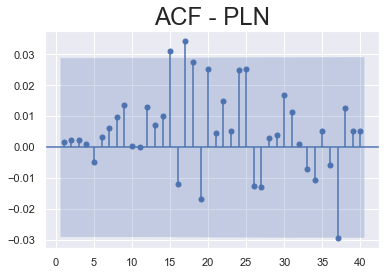

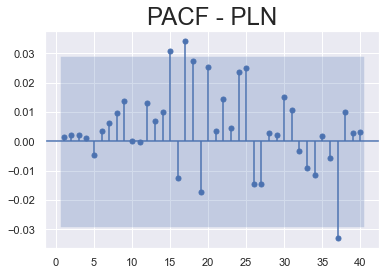

In [471]:
sgt.plot_acf(results_ar_5_ma_5.resid, lags = 40, zero = False)
plt.title("ACF - PLN", size = 24)
sgt.plot_pacf(results_ar_5_ma_5.resid, lags = 40, zero = False)
plt.title("PACF - PLN", size = 24)
plt.show()

We see at lags > 15 residual become not random. 

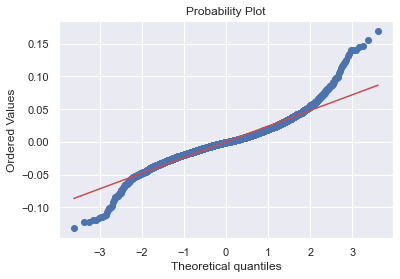

In [462]:
scipy.stats.probplot(results_ar_5_ma_5.resid, plot = pylab)
pylab.show()

We expect from residual to be as like gaussian distributed. 

### ARMA Grid Search

Let's check more models with Grid Search

In [479]:
def grid_ARMA(dataset, p_values, q_values):
    df = pd.DataFrame(columns=['Order','Log Likelihood','AIC'])
    for p in p_values:   
        for q in q_values:
            order = (p,q)
            #print(order)
            try:
                model_ar_p_ma_q = ARMA(dataset, order=(p,q))
                results_ar_p_ma_q = model_ar_p_ma_q.fit(start_ar_lags = p*2)
                #print(f'{results_ar_p_i_d_ma_q.aic=}, {results_ar_p_i_d_ma_q.llf=}')
                df = df.append({'Order' :str(order),
                            'Log Likelihood': results_ar_p_ma_q.llf,
                            'AIC' : results_ar_p_ma_q.aic,
                            'BIC' : results_ar_p_ma_q.bic,},ignore_index=True)
            except:
                print(f'Error for {order}')
                continue
    return df

In [480]:
p_values = range(0,6)
q_values = range(0,6)
df_ARMA = grid_ARMA(df_train.diff_1.values, p_values, q_values)

Error for (1, 3)
Error for (1, 4)
Error for (1, 5)
Error for (2, 3)
Error for (2, 4)
Error for (2, 5)


In [481]:
df_ARMA.sort_values(by=['AIC'], ascending = True)

,Order,Log Likelihood,AIC,BIC
23,"(4, 5)",10368.156148,-20714.312296,-20643.682368
28,"(5, 4)",10364.848469,-20707.696938,-20637.067010
22,"(4, 4)",10360.629336,-20701.258671,-20637.049646
25,"(5, 1)",10358.626392,-20701.252785,-20649.885564
24,"(5, 0)",10357.276232,-20700.552464,-20655.606146
5,"(0, 5)",10356.789096,-20699.578192,-20654.631875
26,"(5, 2)",10358.700459,-20699.400918,-20641.612796
27,"(5, 3)",10359.123662,-20698.247323,-20634.038298
17,"(3, 5)",10358.606672,-20697.213343,-20633.004318
29,"(5, 5)",10360.528620,-20697.057239,-20620.006409


After analysing multiple models only comparing LLF and AIC we see that model p = 4, q = 5 has the best results

In [477]:
start = datetime.now()
model_ar_4_ma_5 = ARMA(df_train.diff_1, order=(4,5))
results_ar_4_ma_5 = model_ar_4_ma_5.fit(start_ar_lags = 7)#update_freq = 5

end = datetime.now()
print(f'Line end at: {end}')
print(f'The process took: {end - start}')
results_ar_4_ma_5.summary()

Line end at: 2020-12-11 17:01:39.611867
The process took: 0:00:57.895860


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 diff_1   No. Observations:                 4541
Model:                     ARMA(4, 5)   Log Likelihood               10368.063
Method:                       css-mle   S.D. of innovations              0.025
Date:                Fri, 11 Dec 2020   AIC                         -20714.127
Time:                        17:01:39   BIC                         -20643.497
Sample:                    02-05-1999   HQIC                        -20689.251
                         - 07-01-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.173e-05      0.000      0.139      0.889      -0.001       0.001
ar.L1.diff_1     0.5684      0.014     39.591      0.000       0.540       0.597
ar.L2.diff_1     0.6468      0.011     57.677      0.000       0.625       0.669
ar.L3.diff_1     0.5919      0.014     41.572      0.000       0.564       0.620
ar.L4.diff_1    -0.9425      0.014    -66.074      0.000      -0.970      -0.915
ma.L1.diff_1    -0.5488      0.021    -26.100      0.000      -0.590      -0.508
ma.L2.diff_1    -0.6915      0.012    -55.379      0.000      -0.716      -0.667
ma.L3.diff_1    -0.6147      0.017    -35.598      0.000      -0.649      -0.581
ma.L4.diff_1     0.9541      0.014     67.770      0.000       0.927       0.982
ma.L5.diff_1     0.0383      0.016      2.333      0.020       0.006       0.070
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6864           -0.7390j            1.0085           -0.3691
AR.2           -0.6864           +0.7390j            1.0085            0.3691
AR.3            1.0004           -0.2058j            1.0213           -0.0323
AR.4            1.0004           +0.2058j            1.0213            0.0323
MA.1           -0.6858           -0.7342j            1.0047           -0.3696
MA.2           -0.6858           +0.7342j            1.0047            0.3696
MA.3            0.9869           -0.1996j            1.0069           -0.0318
MA.4            0.9869           +0.1996j            1.0069            0.0318
MA.5          -25.5068           -0.0000j           25.5068           -0.5000
-----------------------------------------------------------------------------
"""

### ARIMA Manual

#### ARIMA(4,1,5)

In [891]:
start = datetime.now()
model_ar_4_i_1_ma_5 = ARIMA(df_train.PLN, order=(4,1,5))
results_ar_4_i_1_ma_5 = model_ar_4_i_1_ma_5.fit(start_ar_lags = 8)

end = datetime.now()
print(f'Line end at: {end}')
print(f'The process took: {end - start}')
results_ar_4_i_1_ma_5.summary()

Line end at: 2020-12-13 10:37:55.118806
The process took: 0:00:24.089043


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PLN   No. Observations:                 4540
Model:                 ARIMA(4, 1, 5)   Log Likelihood               10365.946
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 13 Dec 2020   AIC                         -20709.892
Time:                        10:37:55   BIC                         -20639.265
Sample:                    02-08-1999   HQIC                        -20685.017
                         - 07-01-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.743e-05      0.000      0.128      0.898      -0.001       0.001
ar.L1.D.PLN     0.5735      0.022     25.587      0.000       0.530       0.617
ar.L2.D.PLN     0.6454      0.014     44.913      0.000       0.617       0.674
ar.L3.D.PLN     0.5838      0.035     16.769      0.000       0.516       0.652
ar.L4.D.PLN    -0.9380      0.027    -34.847      0.000      -0.991      -0.885
ma.L1.D.PLN    -0.5543      0.027    -20.184      0.000      -0.608      -0.501
ma.L2.D.PLN    -0.6903      0.014    -48.779      0.000      -0.718      -0.663
ma.L3.D.PLN    -0.6063      0.037    -16.407      0.000      -0.679      -0.534
ma.L4.D.PLN     0.9521      0.020     48.069      0.000       0.913       0.991
ma.L5.D.PLN     0.0357      0.018      1.988      0.047       0.000       0.071
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6885           -0.7411j            1.0116           -0.3691
AR.2           -0.6885           +0.7411j            1.0116            0.3691
AR.3            0.9997           -0.2059j            1.0207           -0.0323
AR.4            0.9997           +0.2059j            1.0207            0.0323
MA.1           -0.6877           -0.7355j            1.0070           -0.3697
MA.2           -0.6877           +0.7355j            1.0070            0.3697
MA.3            0.9866           -0.1996j            1.0066           -0.0318
MA.4            0.9866           +0.1996j            1.0066            0.0318
MA.5          -27.2883           -0.0000j           27.2883           -0.5000
-----------------------------------------------------------------------------
"""

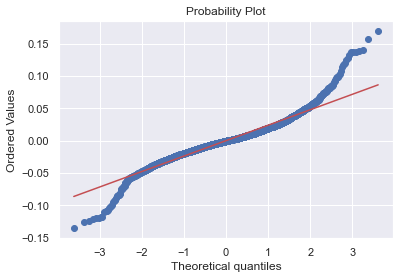

In [530]:
scipy.stats.probplot(results_ar_4_i_1_ma_5.resid, plot = pylab)
pylab.show()

High value of Log Likelihood and low value for AIC plus all parameters are significant. It's look like ARIMA(4,1,5) it's a good model make predictions but good practices is to check also simplest model.

High complex mode can work perfectly with train data but doesn't have any prediction power. 

#### ARIMA(1,1,2)

In [879]:
start = datetime.now()
model_ar_1_i_1_ma_2 = ARIMA(df_train.PLN, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit(start_ar_lags = 2)

end = datetime.now()
print(f'Line end at: {end}')
print(f'The process took: {end - start}')


Line end at: 2020-12-13 10:35:04.085172
The process took: 0:00:00.494706


In [880]:
results_ar_1_i_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PLN   No. Observations:                 4540
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10349.001
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 13 Dec 2020   AIC                         -20688.002
Time:                        10:35:04   BIC                         -20655.898
Sample:                    02-08-1999   HQIC                        -20676.695
                         - 07-01-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.708e-05      0.000      0.147      0.883      -0.001       0.001
ar.L1.D.PLN     0.6298      0.081      7.780      0.000       0.471       0.788
ma.L1.D.PLN    -0.6082      0.081     -7.467      0.000      -0.768      -0.449
ma.L2.D.PLN    -0.0701      0.015     -4.620      0.000      -0.100      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5877           +0.0000j            1.5877            0.0000
MA.1            1.4137           +0.0000j            1.4137            0.0000
MA.2          -10.0868           +0.0000j           10.0868            0.5000
-----------------------------------------------------------------------------
"""

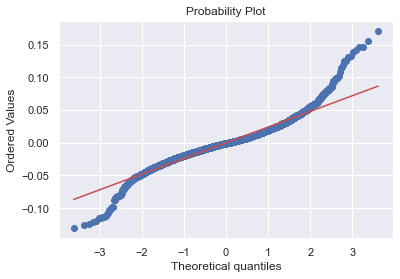

In [881]:
scipy.stats.probplot(results_ar_1_i_1_ma_2.resid, plot = pylab)
pylab.show()

#### ARIMA(0,1,1)

In [857]:
start = datetime.now()
model_ar_0_i_1_ma_1 = ARIMA(df_train.PLN, order=(0,1,1))
results_ar_0_i_1_ma_1 = model_ar_0_i_1_ma_1.fit()

end = datetime.now()
print(f'Line end at: {end}')
print(f'The process took: {end - start}')


Line end at: 2020-12-13 10:12:45.332492
The process took: 0:00:00.419876


In [858]:
results_ar_0_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PLN   No. Observations:                 4540
Model:                 ARIMA(0, 1, 1)   Log Likelihood               10337.255
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 13 Dec 2020   AIC                         -20668.510
Time:                        10:12:46   BIC                         -20649.248
Sample:                    02-08-1999   HQIC                        -20661.726
                         - 07-01-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.861e-05      0.000      0.128      0.898      -0.001       0.001
ma.L1.D.PLN     0.0273      0.016      1.753      0.080      -0.003       0.058
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1          -36.5754           +0.0000j           36.5754            0.5000
-----------------------------------------------------------------------------
"""

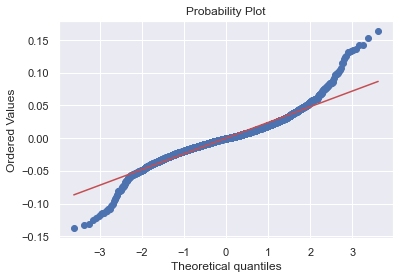

In [859]:
scipy.stats.probplot(results_ar_0_i_1_ma_1.resid, plot = pylab)
pylab.show()

#### Forcasting and Plots

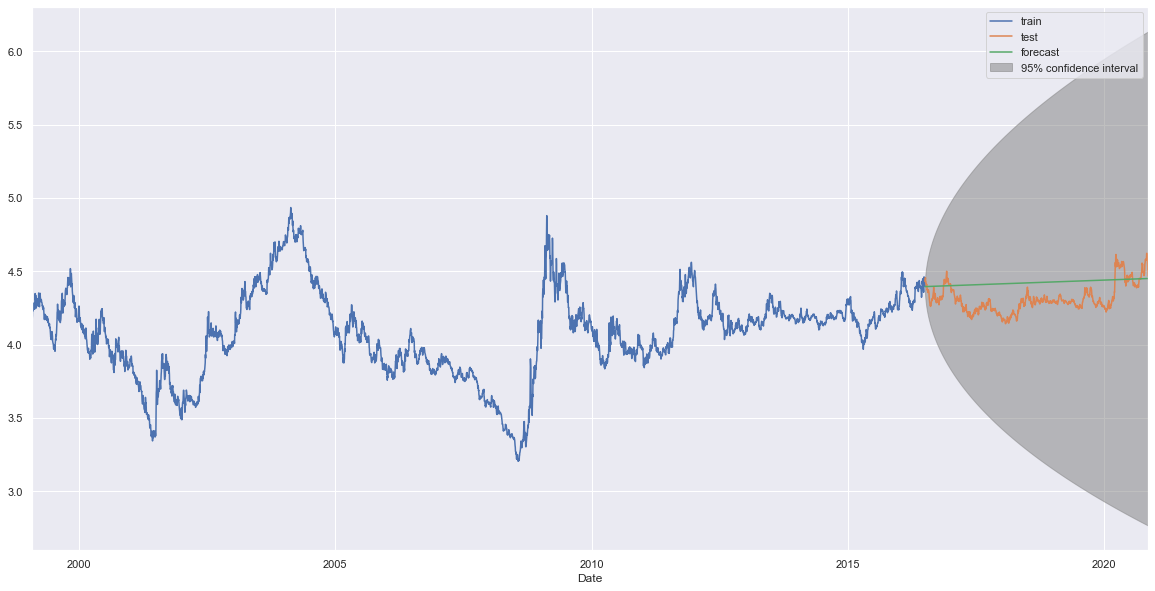

In [897]:
fig, ax = plt.subplots()
ax = df_train.PLN.plot(label="train", figsize = (20,10))
ax = df_test.PLN.plot(label="test")
fig = results_ar_0_i_1_ma_1.plot_predict(start=start_date,end=end_date, dynamic=True, ax=ax, plot_insample=False)
plt.show()

#### Forcasting and Plots

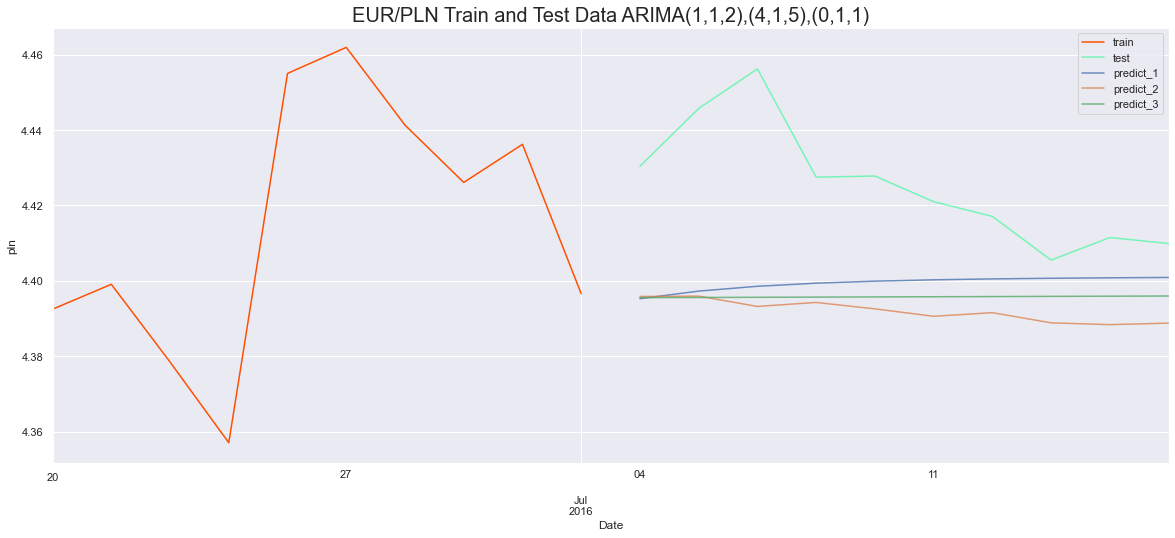

In [868]:
mod_112 = results_ar_1_i_1_ma_2.forecast(len(df_test[start_date:end_date]))
mod_415 = results_ar_4_i_1_ma_5.forecast(len(df_test[start_date:end_date]))
mod_011 = results_ar_0_i_1_ma_1.forecast(len(df_test[start_date:end_date]))

combine_plots(df_train.PLN,df_test.PLN,
              predict=[mod_112,mod_415,mod_011],
              index = s_df.index,
              zoom_start='2016-06-20',
              zoom_end='2016-07-15', 
              Title = 'ARIMA(1,1,2),(4,1,5),(0,1,1)')

We can see that the forecast we get for a long time is only a trend and not a curved line.
Let's use a procedure in which we will refit the model after each forecast.

### Model Cross validation

#### Persistance

We want to have a come kind of reference value that would tall as is models are better or worse.<br>
For this purpose, we will create a new dataset, which will be a 1 shift of our base data set and then we will count for these two sets mean squared error.


In [861]:
train, test = df_train.PLN.values*10000,df_test.PLN.values*10000

In [862]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
reference_result = predictions
print('RMSE: %.6f' % rmse)

RMSE: 124.484147


Value to beat <b>RMSE: 124.484147</b> lower - better

#### ARIMA(0,1,2)

In [532]:
history = [x for x in train]
predictions = list()
list1 = []
list2 = []
for t in range(len(test)):
    model = ARIMA(history,(0,1,2))
    model_fit = model.fit()# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list1.append(yhat)
    list2.append(obs)

In [533]:
rmse = sqrt(mean_squared_error(list2, list1))
print('RMSE: %.6f' % rmse)

RMSE: 0.012561


ARIMA(0,1,2) RMSE: 125.61

#### ARIMA(0,1,3)

In [534]:
history = [x for x in train]
predictions = list()
list3 = []
list4 = []
for t in range(len(test)):
    model = ARIMA(history,(0,1,3))
    model_fit = model.fit()# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list3.append(yhat)
    list4.append(obs)

In [535]:
rmse = sqrt(mean_squared_error(list4, list3))
print('RMSE: %.6f' % rmse)

RMSE: 0.012609


ARIMA(0,1,3) RMSE: 126.09

#### ARIMA(0,1,1)

In [502]:
history = [x for x in train]
predictions = list()
list5 = []
list6 = []
for t in range(len(test)):
    model = ARIMA(history,(0,1,1))
    model_fit = model.fit()# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list5.append(yhat)
    list6.append(obs)

In [503]:
rmse = sqrt(mean_squared_error(list6, list5))
print('RMSE: %.6f' % rmse)

RMSE: 124.417112


<b>RMSE: 124.417112</b> Lowest result

#### ARIMA(1,1,2)

In [608]:
history = [x for x in train]
predictions = list()
list11 = []
list12 = []
for t in range(len(test)):
    model = ARIMA(history,(1,1,2))
    model_fit = model.fit(start_ar_lags = 3)# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list11.append(yhat)
    list12.append(obs)

In [609]:
rmse = sqrt(mean_squared_error(list12, list11))
print('RMSE: %.6f' % rmse)

RMSE: 126.107885


#### ARIMA(1,1,1)

In [560]:
history = [x for x in train]
predictions = list()
list13 = []
list14 = []
for t in range(len(test)):
    model = ARIMA(history,(1,1,1))
    model_fit = model.fit(start_ar_lags = 2)# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list13.append(yhat)
    list14.append(obs)

In [605]:
rmse = sqrt(mean_squared_error(list14, list13))
print('RMSE: %.6f' % rmse)

RMSE: 125.028404


#### ARIMA(4,1,5)

In [491]:
history = [x for x in train]
predictions = list()
list15 = []
list16 = []
for t in range(len(test)):
    model = ARIMA(history,(4,1,5))
    model_fit = model.fit(start_ar_lags = 8)# 
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    #print('predicted=%f, expected=%f' % (yhat, obs))
    list15.append(yhat)
    list16.append(obs)

In [492]:
rmse = sqrt(mean_squared_error(list16, list15))
print('RMSE: %.6f' % rmse)

RMSE: 127.446649


#### Save results

In [521]:
save_data(list15,'ARIMA_4_1_5_List')
save_data(list5,'ARIMA_0_1_1_List')
save_data(list16,'ARIMA_Test_List')
save_data(reference_result,'ARIMA_reference_result_List')

In [635]:
result_4_1_5_CV = list([i[0]/10000 for i in list15])
result_0_1_1_CV = list([i[0]/10000 for i in list5])

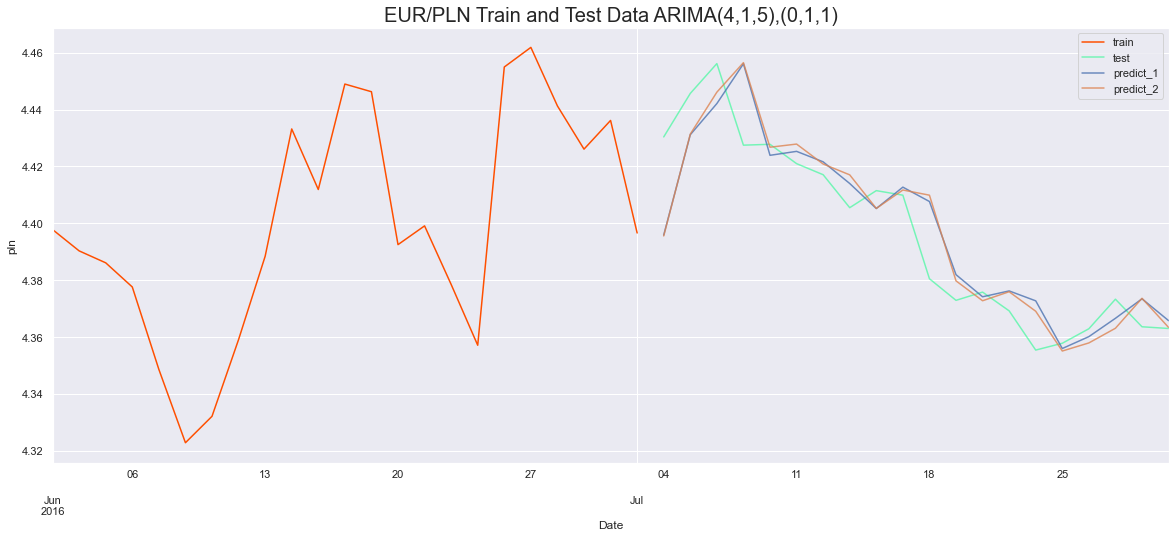

In [864]:
combine_plots(df_train.PLN,df_test.PLN,
              predict=[[result_4_1_5_CV],[result_0_1_1_CV]],
              index = s_df.index,
              zoom_start='2016-06',
              zoom_end='2016-07', 
              Title = 'ARIMA(4,1,5),(0,1,1)')

#### Auto Cross Validation

In [601]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X)*0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0,start_ar_lags = arima_order[0]+1)
        yhat = model_fit.forecast()[0]
        predictions.append(round(yhat[0],4))
        history.append(test[t])
    # calculate out of sample error
    test_data.append((test.tolist(),predictions))
    error = sqrt(mean_squared_error(test.tolist(), predictions))
    return error

In [602]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                #print(order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.8f' % (order,mse))
                except:
                    print(f'Error for {order}')
                    continue
    print('Best ARIMA%s MSE=%.8f' % (best_cfg, best_score))

In [624]:
p_values = [0,]#1,2,3,4,5
d_values = [1,2]
q_values = [1,2,3]#,4,5
warnings.filterwarnings("ignore")
evaluate_models(s_df.PLN.values, p_values, d_values, q_values)

ARIMA(0, 1, 1) MSE=0.00015603
ARIMA(0, 1, 2) MSE=0.00015774
ARIMA(0, 1, 3) MSE=0.00015898
ARIMA(0, 2, 1) MSE=0.00015632
ARIMA(0, 2, 2) MSE=0.00015616
ARIMA(0, 2, 3) MSE=0.00015763
Best ARIMA(0, 1, 1) MSE=0.00015603


In [626]:
print(f'ARIMA(0, 1, 1) MSE={sqrt(0.00015603)*10000}')
print(f'ARIMA(0, 1, 2) MSE={sqrt(0.00015774)*10000}')
print(f'ARIMA(0, 1, 3) MSE={sqrt(0.00015898)*10000}')
print(f'ARIMA(0, 1, 4) MSE={sqrt(0.00015632)*10000}')
print(f'ARIMA(0, 1, 5) MSE={sqrt(0.00015616)*10000}')

ARIMA(0, 1, 1) MSE=124.91196900217369
ARIMA(0, 1, 2) MSE=125.59458587057006
ARIMA(0, 1, 3) MSE=126.08727136392476
ARIMA(0, 1, 4) MSE=125.02799686470226
ARIMA(0, 1, 5) MSE=124.96399481450646


In [ ]:
p_values = [1,2,3,4,5]
d_values = [1,2]
q_values = [1,2,3,4,5]
warnings.filterwarnings("ignore")
evaluate_models(s_df.PLN.values*10000, p_values, d_values, q_values)

ARIMA(1, 1, 1) MSE=15632.16122308
ARIMA(1, 1, 2) MSE=15903.21326275
Error for (1, 1, 3)
Error for (1, 1, 4)
Error for (1, 1, 5)
ARIMA(1, 2, 1) MSE=15612.44836715
ARIMA(1, 2, 2) MSE=15755.69245485
ARIMA(1, 2, 3) MSE=15912.17228716
Error for (1, 2, 4)
Error for (1, 2, 5)
ARIMA(2, 1, 1) MSE=15907.60310133
ARIMA(2, 1, 2) MSE=15934.60984924
Error for (2, 1, 3)
Error for (2, 1, 4)
Error for (2, 1, 5)
ARIMA(2, 2, 1) MSE=15797.44891969
ARIMA(2, 2, 2) MSE=15920.54916347
Error for (2, 2, 3)
Error for (2, 2, 4)
Error for (2, 2, 5)
ARIMA(3, 1, 1) MSE=15906.88684062
Error for (3, 1, 2)
Error for (3, 1, 3)
Error for (3, 1, 4)
Error for (3, 1, 5)
ARIMA(3, 2, 1) MSE=15863.20536105
Error for (3, 2, 2)
Error for (3, 2, 3)
Error for (3, 2, 4)
Error for (3, 2, 5)
ARIMA(4, 1, 1) MSE=15909.49300181
ARIMA(4, 1, 2) MSE=15977.67407431
ARIMA(4, 1, 3) MSE=16142.55311511
ARIMA(4, 1, 4) MSE=16183.89864148


In [196]:
print(f'ARIMA(0, 1, 1) MSE={sqrt(0.00015603)*10000}')
print(f'ARIMA(0, 1, 2) MSE={sqrt(0.00015774)*10000}')
print(f'ARIMA(0, 1, 3) MSE={sqrt(0.00015898)*10000}')
print(f'ARIMA(0, 1, 4) MSE={sqrt(0.00015632)*10000}')
print(f'ARIMA(0, 1, 5) MSE={sqrt(0.00015616)*10000}')
print(f'ARIMA(1, 1, 1) MSE={sqrt(15632.16122308)}')
print(f'ARIMA(1, 1, 2) MSE={sqrt(15903.21326275)}')
print(f'ARIMA(1, 2, 1) MSE={sqrt(15612.44836715)}')
print(f'ARIMA(1, 2, 2) MSE={sqrt(15755.69245485)}')
print(f'ARIMA(1, 2, 3) MSE={sqrt(15912.17228716)}')
print(f'ARIMA(2, 1, 1) MSE={sqrt(15907.60310133)}')
print(f'ARIMA(2, 1, 2) MSE={sqrt(15934.60984924)}')
print(f'ARIMA(2, 2, 1) MSE={sqrt(15797.44891969)}')
print(f'ARIMA(2, 2, 2) MSE={sqrt(15920.54916347)}')
print(f'ARIMA(3, 1, 1) MSE={sqrt(15906.88684062)}')
print(f'ARIMA(3, 2, 1) MSE={sqrt(15863.20536105)}')
print(f'ARIMA(4, 1, 1) MSE={sqrt(15909.49300181)}')
print(f'ARIMA(4, 1, 2) MSE={sqrt(15977.67407431)}')
print(f'ARIMA(4, 1, 3) MSE={sqrt(16142.55311511)}')
print(f'ARIMA(4, 1, 4) MSE={sqrt(16183.89864148)}')

ARIMA(0, 1, 1) MSE=124.91196900217369
ARIMA(0, 1, 2) MSE=125.59458587057006
ARIMA(0, 1, 3) MSE=126.08727136392476
ARIMA(0, 1, 4) MSE=125.02799686470226
ARIMA(0, 1, 5) MSE=124.96399481450646
ARIMA(1, 1, 1) MSE=125.02864161095249
ARIMA(1, 1, 2) MSE=126.1079429011115
ARIMA(1, 2, 1) MSE=124.94978338176502
ARIMA(1, 2, 2) MSE=125.52168121424282
ARIMA(1, 2, 3) MSE=126.14345915329895
ARIMA(2, 1, 1) MSE=126.1253467837849
ARIMA(2, 1, 2) MSE=126.23236450783926
ARIMA(2, 2, 1) MSE=125.68790283750461
ARIMA(2, 2, 2) MSE=126.17665855248347
ARIMA(3, 1, 1) MSE=126.12250727217565
ARIMA(3, 2, 1) MSE=125.94921738958921
ARIMA(4, 1, 1) MSE=126.13283871304094
ARIMA(4, 1, 2) MSE=126.40282462947575
ARIMA(4, 1, 3) MSE=127.05334751634842
ARIMA(4, 1, 4) MSE=127.21595277904419


### Summary ARIMA validation

Reference model <b>RMSE: 124.963323</b>

Model with the smolest MSE value is ARIMA(0,1,1) <b>MSE=124.911</b>

From all models simplest model ARIMA(0,1,1) turned out to be the best.




### Auto ARIMA

Auto Arima is a library that allows you to automatically search for the optimal p, d, q parameters. We will also expand the model with exogenous data.

#### Model 1

In [793]:
df_train.columns

Index(['PLN', 'wn', 'rw', 'log', 'log_moving_avg', 'log_moving_avg_diff',
       'expwighted_avg', 'log_ewma_diff', 'returns', 'diff_1', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'CHF_lag_5', 'HUF_lag_5',
       'NOK_lag_5', 'Exch rate_lag_5'],
      dtype='object')

In [847]:
exog_list = ['CHF_lag_5','Exch rate_lag_5','lag_2']

In [848]:
model_auto = auto_arima(df_train.PLN, m = 1, d = 0, exogenous = df_train[exog_list],
                       max_order = None, max_p = 7, max_q = 7, max_d = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = 2, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_train.PLN)*0.2))

In [849]:
model_auto

ARIMA(order=(0, 0, 4), scoring_args={}, trend='ct')

In [850]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4541
Model:               SARIMAX(0, 0, 4)   Log Likelihood               10305.497
Date:                Sat, 12 Dec 2020   AIC                         -20590.993
Time:                        18:55:00   BIC                         -20526.784
Sample:                    02-05-1999   HQIC                        -20568.379
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0002      0.048      0.003      0.997      -0.094       0.095
drift           -1.004e-07   1.19e-06     -0.085      0.933   -2.43e-06    2.23e-06
CHF_lag_5          -0.0061      0.009     -0.660      0.509      -0.024       0.012
Exch rate_lag_5     0.0002      0.000      0.660      0.509      -0.000       0.001
lag_2               0.9975      0.007    139.942      0.000       0.984       1.011
ma.L1               0.9318      0.010     96.575      0.000       0.913       0.951
ma.L2              -0.0446      0.015     -2.984      0.003      -0.074      -0.015
ma.L3              -0.0645      0.015     -4.319      0.000      -0.094      -0.035
ma.L4              -0.0702      0.010     -6.975      0.000      -0.090      -0.050
sigma2              0.0007   8.49e-06     78.943      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      114.08   Jarque-Bera (JB):              5315.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [851]:
predictrion_auto_arima = model_auto.predict(n_periods = len(df_test[start_date:end_date]),exogenous = df_test[exog_list]).tolist()


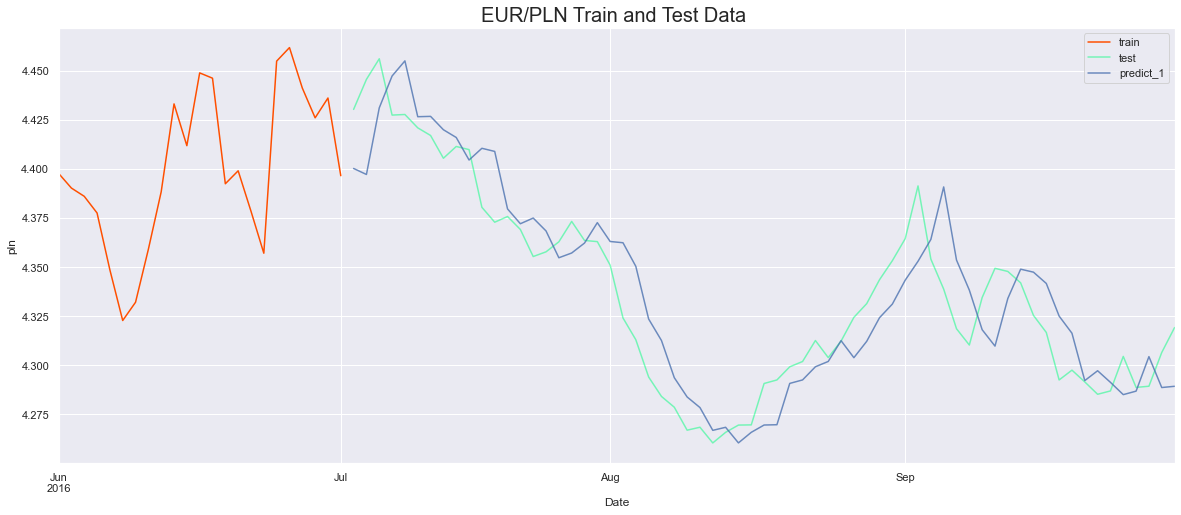

In [852]:
combine_plots(df_train.PLN, df_test.PLN,
              predict=[[predictrion_auto_arima]],
              index = s_df.index,
              zoom_start='2016-06',
              zoom_end='2016-09')

In [853]:
rmse = sqrt(mean_squared_error(df_test.PLN, predictrion_auto_arima))*10000
print('RMSE: %.6f' % rmse)

RMSE: 178.745104


#### Model 2

In [818]:
exog_list2 = ['lag_5','lag_4','lag_3','lag_2','CHF_lag_5','HUF_lag_5','Exch rate_lag_5']

In [825]:
model_auto2 = auto_arima(df_train.PLN, m = 1,d=0, exogenous = df_train[exog_list2],
                       max_order = None, max_p = 7, max_q = 7, max_d = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = 2, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_train.PLN)*0.2))

In [826]:
model_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4541
Model:               SARIMAX(0, 0, 4)   Log Likelihood               10275.596
Date:                Sat, 12 Dec 2020   AIC                         -20523.192
Time:                        18:44:44   BIC                         -20433.300
Sample:                    02-05-1999   HQIC                        -20491.532
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        3.155e-05      0.059      0.001      1.000      -0.115       0.115
drift            -3.73e-08   1.51e-06     -0.025      0.980   -2.99e-06    2.92e-06
lag_5               0.0517      0.113      0.456      0.648      -0.170       0.274
lag_4               0.0452      0.136      0.333      0.739      -0.221       0.311
lag_3              -0.0609      0.113     -0.540      0.589      -0.282       0.160
lag_2               0.9696      0.134      7.211      0.000       0.706       1.233
CHF_lag_5          -0.0219      0.010     -2.217      0.027      -0.041      -0.003
HUF_lag_5          -0.0001   6.16e-05     -2.199      0.028      -0.000   -1.47e-05
Exch rate_lag_5     0.0004      0.000      1.425      0.154      -0.000       0.001
ma.L1               0.9169      0.010     92.591      0.000       0.897       0.936
ma.L2              -0.0179      0.134     -0.134      0.894      -0.280       0.245
ma.L3               0.0195      0.161      0.121      0.904      -0.297       0.336
ma.L4              -0.0335      0.110     -0.304      0.761      -0.250       0.183
sigma2              0.0007   8.91e-06     76.222      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      118.71   Jarque-Bera (JB):              5212.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [827]:
predictrion_auto_arima2 = model_auto2.predict(n_periods = len(df_test[start_date:end_date]),exogenous = df_test[exog_list2]).tolist()

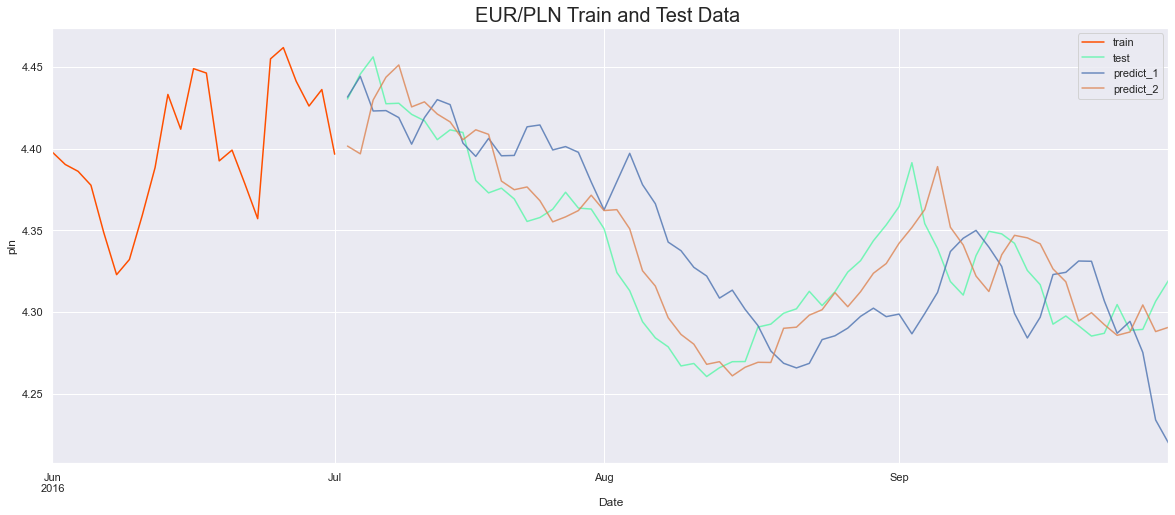

In [828]:

combine_plots(df_train.PLN, df_test.PLN,
              predict=[[predictrion_auto_arima],[predictrion_auto_arima2]],
              index = s_df.index,
              zoom_start='2016-06',
              zoom_end='2016-09')

In [829]:
rmse = sqrt(mean_squared_error(df_test.PLN, predictrion_auto_arima2))*10000
print('RMSE: %.6f' % rmse)

RMSE: 182.936625


## Predict real feature

Let's try to predict real feature. 
I will use all data I have to train the ARIMA model and will compare it with the result that we will get from ML models.
We will use mode without any exogenous data.

In [842]:
s_df[:-2].PLN

Date
1999-02-23    4.2408
1999-02-24    4.2813
1999-02-25    4.3051
1999-02-26    4.3482
1999-03-01    4.3074
               ...  
2020-10-30    4.6222
2020-11-02    4.6018
2020-11-03    4.5680
2020-11-04    4.5368
2020-11-05    4.5134
Name: PLN, Length: 5663, dtype: float64

In [909]:
model_forecast = ARIMA(s_df[:-2].PLN,(0,1,1))
model_fit = model.fit()# 
output = model_fit.forecast(2)
output[0]

array([45267.42154732, 45268.0400499 ])

In [910]:
s_df[-2:].PLN.values

array([4.5263, 4.467 ])

In [911]:
output[0]/10000 - s_df[-2:].PLN.values

array([0.00044215, 0.059804  ])

Let's move to next chapter P03-Forcasting_with_ML_Model